<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


In this lab, you will create a machine learning pipeline to predict if the first stage will land given the data from the previous labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planned. SpaceX performs controlled landings in the oceans.

## Objectives


Perform exploratory data analysis and determine training labels.

*   Create a column for the class
*   Standardize the data
*   Split into training data and test data
*   Find the best hyperparameters for SVM, Classification Trees, and Logistic Regression
*   Find the method performs best using test data

## Importing Libraries and Defining Auxiliary Functions

In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
def plot_confusion_matrix(y, y_predict):
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['did not land', 'landed']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


### TASK  1: Create a column for the target


Create a NumPy array from the column <code>Class</code> in <code>data</code> by applying the method <code>to_numpy()</code>, then
assign it to the variable <code>Y</code>.


In [8]:
Y = data['Class'].to_numpy()

### TASK  2: Standardize the data


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

Split the data into training and testing data using the function <code>train_test_split</code>. The training data is divided before the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.

### TASK  3: Split the data for training and testing

Use the function `train_test_split` to split the data X and Y into training and test data. Set the parameter test_size to 0.2 and random_state to 2. The training data and test data should be assigned to the following labels: <code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

### TASK  4: Find the optimal hyperparameters for logistic regression

Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [11]:
parameters = {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']}
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

Display the best parameters using the attribute <code>best_params\_</code> and the accuracy on the validation data using the attribute <code>best_score\_</code>.

In [12]:
print("Tuned Hyperparameters: (Best Parameters) ", logreg_cv.best_params_)
print("Accuracy :", logreg_cv.best_score_)

Tuned Hyperparameters: (Best Parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8464285714285713


### TASK  5: Evaluate the optimal logistic regression model


Calculate the accuracy on the test data using the method <code>score</code>:


In [13]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

Take a look at the confusion matrix:


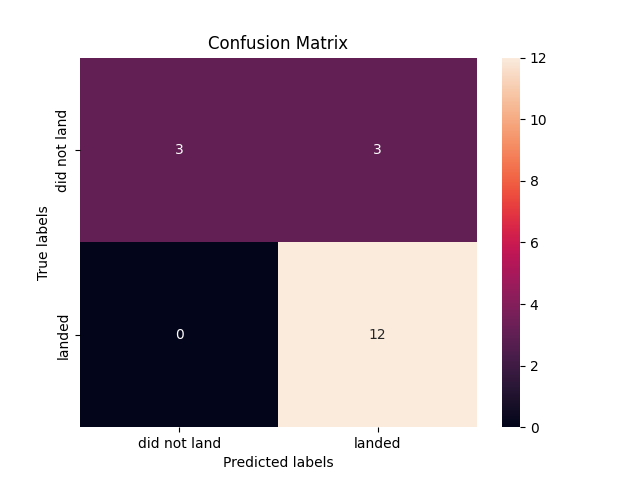

In [14]:
Y_hat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, Y_hat)

Examining the confusion matrix, it is clear that logistic regression can distinguish between the different classes. The major problem, however, is the number of false positives.

### TASK  6: Find the optimal hyperparameters for the SVM algorithm


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10. Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [15]:
parameters = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(-3, 3, 5), 'gamma': np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [16]:
print("Tuned Hyperparameters: (Best Parameters) ", svm_cv.best_params_)
print("Accuracy :", svm_cv.best_score_)

Tuned Hyperparameters: (Best Parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy : 0.8482142857142856


### TASK  7: Evaluate the optimal SVM


Calculate the accuracy on the test data using the method <code>score</code>:


In [17]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

Take a look at the confusion matrix:

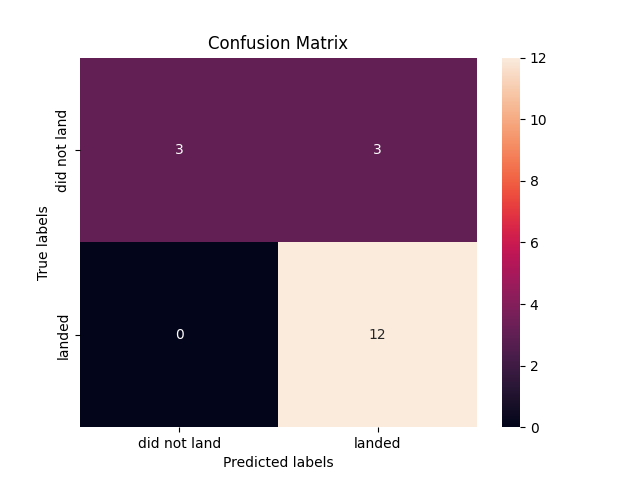

In [18]:
Y_hat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, Y_hat)

### TASK  8: Find the optimal hyperparameters for the decision tree algorithm


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [19]:
parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [2*n for n in range(1,10)], 'max_features': ['auto', 'sqrt'], 
              'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [20]:
print("Tuned Hyperparameters: (Best Parameters) ", tree_cv.best_params_)
print("Accuracy :", tree_cv.best_score_)

Tuned Hyperparameters: (Best Parameters)  {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
Accuracy : 0.8875


### TASK  9: Evaluate the optimal decision tree classifier

Calculate the accuracy on the test data using the method <code>score</code>:

In [21]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

Take a look at the confusion matrix:

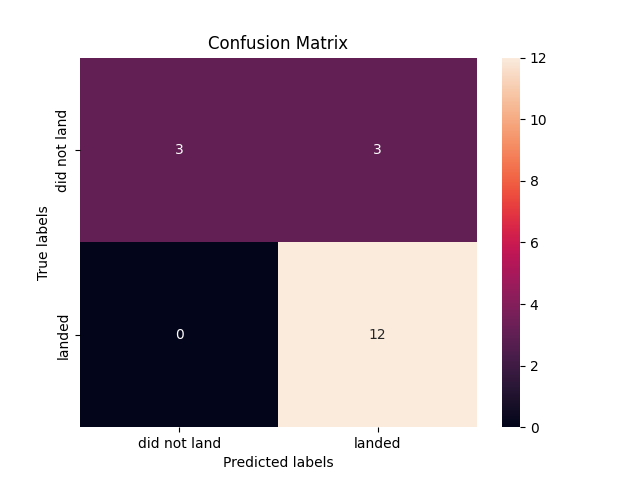

In [22]:
Y_hat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, Y_hat)

### TASK  10: Find the optimal hyperparameters for the KNN algorithm


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [23]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1,2]}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [24]:
print("Tuned Hyperparameters: (Best Parameters) ", knn_cv.best_params_)
print("Accuracy :", knn_cv.best_score_)

Tuned Hyperparameters: (Best Parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Accuracy : 0.8482142857142858


### TASK  11: Evaluate the optimal KNN classifier


Calculate the accuracy on the test data using the method <code>score</code>:

In [25]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

Take a look at the confusion matrix:

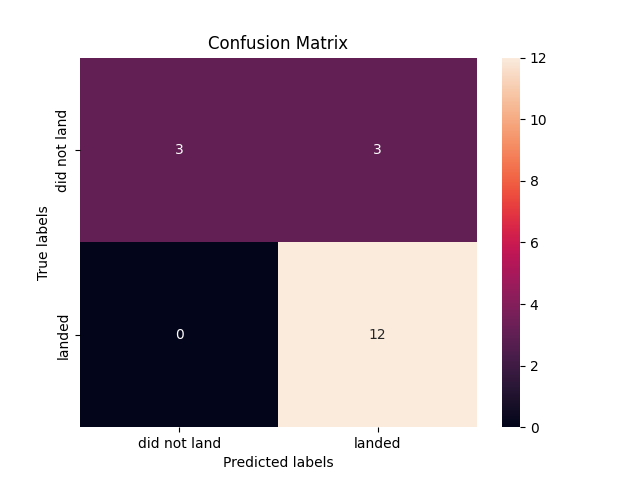

In [26]:
Y_hat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, Y_hat)

### TASK  12: Find the method that performs the best


In [27]:
methods = [logreg_cv, svm_cv, tree_cv, knn_cv]
best_method = ''
best_score = 0
for method in methods:
    score = method.score(X_test, Y_test)
    if score > best_score:
        best_score = score
        best_method = method

print(f"The best method is {best_method} with an accuracy of {best_score} on the test data")

The best method is GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']}) with an accuracy of 0.8333333333333334 on the test data


## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
